# Data 200 - Grad Project

Sverre Rynning-Tønnesen, Isabel Slorer, Hans Erik Heum

## Structure


1) Introduction <br>
2) Data Sampling and Collection <br>
3) Data Cleaning <br>
4) Exploratory Data Analysis <br>
5) Feature Engineering <br>
6) Data Modeling and Inferences <br>
7) Conclusion <br>

### Introduction

This notebook is meant to complement the project writeup and give a understanding of how we have collected, processed and modeled all the data displayed in the writeup. We will describe the steps we have taken with both code and text but to get a full understanding of the project, its goal and results we suggest reading this together with the writeup

### Data Sampling and Collection

In [ ]:
#Load all important libraries
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import datetime

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge

import plotly as go
import plotly.graph_objects as go

import plotly.graph_objs as go
import pandas as pd
from plotly.offline import iplot, init_notebook_mode
import warnings
warnings.filterwarnings('ignore')


### Import necessary datasets

#### Import Covid Restrictions Data
The first dataframe we download contains information about multiple covid restrictions in the US for all the states. The data is between 2020-06-04 and 2021-11-09 and is taken from KFF (Kaiser Family Foundation) which is a nonprofit organization focusing on national health issues, as well as the U.S. role in global health policy.

The information has been updated daily and compiled from a review of state executive orders, guidance documents, policy bulletins, and news releases. There are some missing values in the dataset because of the different methods used to gather the data but the data should not be affected by either selection bias, response bias no non-response bias.

In [ ]:

#initialize state_social_distancing_d
def init_state_social_distancing_actions(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      # if not text_file.filename.startswith('__MACOSX/'):
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        if date == "20201-06-01":
          date = "2021-06-01"
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Unnamed: 0':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

state_social_distancing_actions = init_state_social_distancing_actions(r'**csv_files/state_social_distancing_actions.zip')



#### Import additional covid restrictions data

In [ ]:
def init_restriction_df(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

restrictions_df = init_restriction_df(r'csv_files/updated_restrictions.csv.zip', ["STATE"])

#### Import vaccination data

The vaccination data is taken from CDC (Center for Disease Control and Prevention). It contains time specific information about the distribution and administration for different vaccines in different states. The data range is from 2020-12-14 to 2022-04-20.

The data contained in the database have been gathered by CDC themselves and the database have been updated daily.

In [ ]:
def init_vaccination_df_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

vaccination_df = init_vaccination_df_from_zip(r'**csv_files/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv.zip', ["Date"])
vaccination_df = vaccination_df[vaccination_df["Location"] == "CA"]
vaccination_df.index = pd.to_datetime(vaccination_df.index)
vaccination_df.sort_index(inplace=True)
vaccination_df.head(5)

#### Import death rate data
The data repository containing data about the death rate is operated by JHUCSSE (Johns Hopkins University Center for System Science and Engineering). They have gathered data from multiple different sources which can be found at this address. The data range is between 2020-04-12 and 2022-03-29. Also, becuase the data is gathered from so many different sources it is hard to tell whether it it subject to a bias or not.

In [ ]:
def init_daily_reports(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      # if not text_file.filename.startswith('__MACOSX/'):
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Province_State':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

covid_daily_reports = init_daily_reports(r'**csv_files/csse_covid_19_daily_reports_us.zip')

#### Import infection data
The infection data is taken from CDC (Center for Disease Control and Prevention). It contains date specific information about the current number of people infected by Covid-19 in different states. The data range is from 2020-01-22 to 2022-04-18. The data contained in the database have been gathered by CDC themselves and posted daily.

This data is not completely accurate and the reason for this is that it is impossible for CDC to count exact the exact number of covid infections at a given time. COVID-19 can cause mild illness, symptoms might not appear immediately, there are delays in reporting and testing, not everyone who is infected gets tested or seeks medical care, and there are differences in how completely states and territories report their cases

In [ ]:
def init_infection_dataframe_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

infected_df = init_infection_dataframe_from_zip(r'**csv_files/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv.zip', ["submission_date", "state"])

#### Import death counts by sex, age & state

The death count data is also taken from CDC. It contains time specific information about the number different death cases together with state, age and sex. The data range is between 01/01/2020 and 04/23/2022.

The provisional counts for coronavirus disease 2019 (COVID-19) deaths are based on a current flow of mortality data in the National Vital Statistics System. One should note that this data might not be 100% accurate. The reason is (as explained by CDC):

- National provisional counts include deaths occurring within the 50 states and the District of Columbia that have been received and coded as of the date specified. It is important to note that it can take several weeks for death records to be submitted to National Center for Health Statistics (NCHS), processed, coded, and tabulated. Therefore, the data shown on this page may be incomplete, and will likely not include all deaths that occurred during a given time period, especially for the more recent time periods.

In [ ]:
df_sex_age = pd.read_csv('csv_files/cdc_death_counts_by_sex_age_state.zip',header=0)
df_sex_age.head(5)


#### Import death counts by conditions

The death count data is also taken from CDC. It contains time specific data about Covid-19 related deaths including potential contributing causes. The data range is between 01/01/2020 and 04/23/2022.

As with the "death counts by sex, age & state" data, this data will not be a 100% accurate based on the same reasoning.

In [ ]:
df_condition = pd.read_csv('csv_files/cdc_death_counts_by_conditons.zip',header=0)
df_condition.head(5)


#### Import Anxiety and Depression data

The anxiety and depression data is also taken from CDC. It shows the percentage of different age groups who have reported symptoms of anxiety and depression over different time periods. The data is gathered in three different periods/phases. Phase 1 was between April 23, 2020 and July 21, 2020. Phase 2 occured between August 19, 2020 and October 26, 2020. Phase 3 occurred between October 28, 2020 and March 29, 2021.

The data was gathered through a 20-minute online survey. It was conducted by an internet questionnaire, with invitations to participate sent by email and text message. Housing units linked to one or more email address or phone number were randomly selected to participate. And the estimates are weighted to adjust for non-response bias. However, the data might still be affected by the non-response bias. In addition the responses are probably affected by selection and response bias as well. Because not all houses have a contact person listed with a phone or mail it is not representative for the whole population, and it is hard to validate if the information given was correct.

In [ ]:
df_anx_dep = pd.read_csv('csv_files/nchs_covid_indicators_of_anxiety_depression.zip',header=0)
df_anx_dep.head(5)


## 2. Data Cleaning

Clean up the dataframe to remove unused columns and solve for Nan fields.

- Have to manually insert face mask requirements for recent months based on: https://statepolicies.com/data/graphs/face-masks/
- Face mask mandate was reintroduced from Dec 15, 2021 -> Feb 15, 2022
Other changes

- Manually inserted "No Limit" after 2021-08-15 because missing data
### Clean restriction data

The rows in the restriction data contain information about the dates that the restrictions have changed and shows the data for each state. This means that the data has missing values for all the dates where there was no updates. In addition the dataset have a lot of missing values which we had to handle in different ways depending on the specific restrictions. We also chose to just look at California.
The steps taken to clean the data was:

- Fill inn all the dates with missing data. Because the data had not changed on the missing days we filled the gaps with the same data as the previous valid row.
- For the face mask restriction we had to manually fix the dataset b- ecuase there were so much missing data. The data was taken from Covid-19 US State Policies
- For the large gatherings ban the missing data was the last dates where there were no restrictions so we filled this data with "No Limit"
- Then we converted the severity values into discrete numbers ranging from 1 to 5: (1: no restrictions, 5: All gatherings prohibited)
- Finally we searched up the restaurant restrictions and found that the missing data was all days where the restaurants were open so we changed that and also we one-hot encoded that data.
Below we have plotted a the missing values (Yellow) and the values with data to show where the data is missing.

In [ ]:
california_data = state_social_distancing_actions[state_social_distancing_actions.index.get_level_values('State').isin(['California'])]
ax = plt.axes()
sns.heatmap(california_data[["Face Covering Requirement", "Large Gatherings Ban", "Restaurant Limits"]].isnull(),yticklabels = False, cbar = False, cmap='viridis', ax=ax)
ax.set_title("Missing Values (yellow) for the Restrictions Data");

In [ ]:
california_data.reset_index("State", inplace=True)
california_data = california_data[~california_data.index.duplicated(keep='first')]
# Fill inn missing dates with rows equal the previous date with data
days_idx = pd.date_range(start=california_data.index[0], end="2022-04-18", freq="D")
california_data = california_data.reindex(days_idx, method="pad")
# Update facemask data
california_data.loc[: "2020-06-17", "Face Covering Requirement"] = 0 # No
california_data.loc["2020-06-18" : "2021-06-14", "Face Covering Requirement"] = 1 # Yes
california_data.loc["2021-06-15" : "2021-12-14", "Face Covering Requirement"] = 0
california_data.loc["2021-12-15" : "2022-02-14", "Face Covering Requirement"] = 1
california_data.loc["2022-02-15" : , "Face Covering Requirement"] = 0
# Manually insert gathering limit for missing values
california_data.loc["2021-08-16 ":, "Large Gatherings Ban"] = "No Limit"
# Transform Large Gatherings Ban to a sevearity of the rules (1: no restrictions, 5: All gatherings prohibited)
california_data["Large Gatherings Ban"].replace({'All Gatherings Prohibited': 5, '>50 Prohibited': 4, 'Expanded Limit to 25 or Fewer': 3, '>25 Prohibited': 3, '>10 Prohibited': 2, 'No Limit': 1}, inplace=True)
# Set the missing restaurant values to open
california_data[california_data["Restaurant Limits"].isna()]["Restaurant Limits"] = "Open"

ohe_restaurant_limits = pd.get_dummies(california_data["Restaurant Limits"], prefix='Restaurant Limits', columns = 'Restaurant Limits')

selected_ca_restrictions = pd.concat([california_data[["Face Covering Requirement", "Large Gatherings Ban"]], ohe_restaurant_limits], axis=1)




#### Clean new restrictions data

In [ ]:
restrictions_df = restrictions_df[restrictions_df.index.notnull()]
restrictions_df.replace("0", np.nan, inplace=True)

In [ ]:
start_date = "2020-06-04"
end_date = "2022-03-28"

def add_missing_data(df, start, end):
  days_idx = pd.date_range(start=start, end=end, freq="D")
  days_with_missing_data = df.reindex(days_idx, fill_value=0)
  days_with_missing_data.index.names = ['date']
  df = days_with_missing_data.append(df)
  return df
  
single_restr = restrictions_df.loc[:, ["CLDAYCR", "OPNCLDCR", "STAYHOME", "END_STHM", "CLBSNS", "END_BSNS"]]
single_restrictions = pd.DataFrame({})

for i, j in zip(range(0, len(single_restr.columns), 2), range(1, len(single_restr.columns)+1, 2)):
  start_day = single_restr.columns[i]
  end_day = single_restr.columns[j]
  dates = single_restr.loc["California", [start_day, end_day]]
  
  if (isinstance(dates[0], str) and isinstance(dates[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates[0], dates[1]), 
                    single_restr.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates[0]) # now we will overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]
    single_restrictions = pd.concat([single_restrictions, fill_end], axis=1)
single_restrictions.fillna(0)
single_restrictions.rename(columns={"STAYHOME": "Stay at home order", "CLBSNS": "Closed other non-essential businesses", "CLDAYCR": "Closed day cares"}, inplace=True)


In [ ]:
double_restrictions = restrictions_df.loc[:, ["CLREST", "ENDREST", "CLRST2", "ENDREST2", "CLGYM", "ENDGYM", "CLGYM2", "END_CLGYM2", "CLMOVIE", "END_MOV", "CLMV2", "END_CLMV2", "CLOSEBAR", "END_BRS", "BCLBAR2", "END_BRS2"]]
double_restrictions_conv = pd.DataFrame({})

for i in range(0, len(double_restrictions.columns), 4):
  start_day_first = double_restrictions.columns[i]
  end_day_first = double_restrictions.columns[i+1]
  start_day_second = double_restrictions.columns[i+2]
  end_day_second = double_restrictions.columns[i+3]
  dates_first = double_restrictions.loc["California", [start_day_first, end_day_first]]
  dates_second = double_restrictions.loc["California", [start_day_second, end_day_second]]
  
  if (isinstance(dates_first[0], str) and isinstance(dates_first[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates_first[0], dates_first[1]), 
                    double_restrictions.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates_first[0]) # now we might overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates_first[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]

    if (isinstance(dates_second[0], str) and isinstance(dates_second[1], str)):
      fill_end.loc[dates_second[0]:dates_second[1], double_restrictions.columns[i]] = 1

    double_restrictions_conv = pd.concat([double_restrictions_conv, fill_end], axis=1)

double_restrictions_conv = double_restrictions_conv.fillna(0)
double_restrictions_conv.rename(columns={"CLREST": "Closed restaurants", "CLGYM": "Closed gym", "CLMOVIE": "Closed movie theaters", "CLOSEBAR": "Closed bars"}, inplace=True)




In [ ]:
combined_restrictions = pd.concat([double_restrictions_conv, single_restrictions], axis=1)
combined_restrictions = combined_restrictions["2020-06-04" : "2022-03-28"]

merged_data = pd.concat([combined_restrictions, selected_ca_restrictions], axis=1)
sns.heatmap(merged_data==1, yticklabels = False, cbar = False, cmap='viridis');

#### Clean vaccination data


Each row of the vaccination data is a single date and contains information about distribution and administration of different vaccines. Much of this data incluting the total number of distributed vaccines are cumulative. The dataset do not start before the end of 2020 becuase we did not start to vaccinate people before then. To be able to merge this dataset with the others we therefore add all the dates from 2020-06-04 and set the number of vaccines distributed and administered for those days to 0. One problem with the data is that on the date 2022-01-27 the number of vaccines suddenly drops. However, this drop is not to large based on the whole dataset so we chose to not do anything with it since there is still a high number of administered vaccines.

In [ ]:
days_idx = pd.date_range(start="2020-06-04", end="2020-12-13", freq="D")
days_with_missing_data = vaccination_df.reindex(days_idx, fill_value=0)
days_with_missing_data["Location"] = "CA"
days_with_missing_data.index.names = ['Date']
vaccination_df = days_with_missing_data.append(vaccination_df)

vaccination_df_administered = pd.DataFrame(vaccination_df["Administered"])
vaccination_df_administered.rename(columns={"Administered": "Total Vaccines Administered"}, inplace=True)
vaccination_df_administered

#### Clean daily covid deaths

The rows in the daily covid deaths data contains the number of deaths in each state for each date. We chose to look at the "Deaths" column which had no missing values. This column is cumulative so we made new column from this to get the daily number of new deaths. What we then found out was that we had some rows with a negative number of dead people. This is probably becuase someone have gone in and corrected some errors in the data and what we did to reduce this error was to set all these negative values to 0.

In [ ]:
covid_daily_reports = covid_daily_reports.reset_index()
states = ['California']
covid_daily_reports = covid_daily_reports[covid_daily_reports["State"].isin(states) == True]
covid_daily_reports.set_index(["Date"], inplace=True)

deaths_data = pd.DataFrame(covid_daily_reports["Deaths"])
deaths_data["Daily Deaths"] = deaths_data.diff(periods=1)
deaths_data = deaths_data[~deaths_data.index.duplicated(keep='first')] 
deaths_data.drop(["Deaths"], axis=1, inplace=True)

deaths_data[deaths_data["Daily Deaths"] < 0] = 0
deaths_data.head(5)


#### Clean infection rate data
This dataset contains information about the daily number of new cases of covid 19. We chose to take out the number of daily infections instead of the cumulative number of infections becuase it makes more sense if the model sees the current infections. Also there were 3 days where the number of infections were negative (between -3401 and -4803). To remove these invalid values we inserted 0 instead.

In [ ]:
infected_df.index = infected_df.index.set_levels([pd.to_datetime(infected_df.index.levels[0]), infected_df.index.levels[1]])
infected_df.rename(columns={"new_case": "Daily New Infections"}, inplace=True)
infected_df_CA = infected_df[infected_df.index.get_level_values('state').isin(['CA'])]
infected_df_CA = infected_df_CA.reset_index()
infected_df_CA.set_index(["submission_date"], inplace=True)
infected_df_CA = infected_df_CA[["Daily New Infections"]].sort_index()
infected_df_CA[infected_df_CA["Daily New Infections"] < 0] = 0


#### Merge Restrictions, Vaccination, Infections and Deaths
Make sure all dataframes share the same date-time range

In [ ]:
merged_data = pd.concat([selected_ca_restrictions["2020-06-04" : "2022-03-28"], vaccination_df_administered["2020-06-04" : "2022-03-28"], infected_df_CA["2020-06-04" : "2022-03-28"], deaths_data["2020-06-04" : ],combined_restrictions], axis=1)
merged_data.head(5)

#### Clean Deaths by Sex, Age & State

The rows in the Deaths by Sex, Age & State data contains deaths by age and sex grouped on month, year and total. Becuase we are interested in the least time intervel we only look at deaths per month. In addition we have to filter on the states because there were some locations like "USA" that weren't states.

In [ ]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
df_sex_age = df_sex_age[df_sex_age["State"].isin(states) == True]
df_sex_age = df_sex_age[df_sex_age["Group"] == 'By Month'] 

df_sex_age["End Date"] = pd.to_datetime(df_sex_age["End Date"])


#### Clean condition data

The rows in the Conditions data contains deaths with the contributing/underlying condition grouped on month, year and total. Becuase we are interested in the least time intervel we only look at deaths per month. In addition we have to filter on the states because there were some locations like "USA" that weren't states.

In [ ]:
df_condition = df_condition[df_condition["State"].isin(states) == True]
df_condition = df_condition[df_condition["Group"] == 'By Month'] 

In [ ]:
df_anx_dep.head()

#### Clean anxiety data

Each rows in this dataset contains information about respondents from different age groups and their mental health value. This dataset has aggregated data grouped by _Education_, _By Age_,_State_ etc. Since we are analyzing mental health data together with restrictions particularly in California, we have to extract data only considering this state. The way this data is organizied causes us to lose important information such as age, sex and education. <br>

The restriction data contains change in restriction for every day. The mental health data is aggregated over longer periods varying from 7-25 days. To be able to merge the datasets together, we group all the restriction data in the mental health data's timespans and take the average. Afterwards we concenate the rows, such that each row contain information about the mental health value in a time period together with the average restricitons in the same period. <br>

For each time span the mental health data consists of three different values: _Symptoms of Depressive Disorder, _Symptoms of Anxiety Disorder_ or both of them. When evaluating mental health we concluded it was beneficial to aggregate these values to one. This value will be a measurement of the overall mental health rating in this time span. <br>
Afterwards we dropped a column, which also contains information regarding the date. We also dropped information about the confidence interval of the mental health value - because it will leak information to the mental health value which we are trying to predict. 

In [ ]:
df_anx_dep2 = df_anx_dep[df_anx_dep['State']=='California']

merged_no_index = merged_data.copy().reset_index()
merged_no_index['index'] = pd.to_datetime(merged_no_index['index'])
restriction_mental = pd.DataFrame()
for index, row in df_anx_dep2.iterrows():
    first_date = pd.to_datetime(row['Time Period Start Date'])
    last_date = pd.to_datetime(row['Time Period End Date'])
    
    interval_rows = merged_no_index[(merged_no_index['index']>= first_date) & (merged_no_index['index']<= last_date)]
    interval_rows = pd.DataFrame(interval_rows.mean()).T
    row = pd.DataFrame(row).T
    interval_rows.rename(index={0:row.index[0]},inplace=True) 
    result = pd.concat([row,interval_rows], axis=1,join='inner')
    restriction_mental = pd.concat([restriction_mental,result],axis = 0)
    
restriction_mental= restriction_mental.fillna(0)
restriction_mental.rename({"Value": "Mental Health Score"}, axis=1, inplace=True)

In [ ]:
restriction_mental['Mental Health Score'] = restriction_mental['Mental Health Score'].astype(float)
restriction_mental = restriction_mental.groupby('Time Period End Date').mean()
restriction_mental.index = pd.to_datetime(restriction_mental.index)
restriction_mental = restriction_mental.sort_index()
restriction_mental = restriction_mental.drop(["Time Period",'Low CI','High CI'], axis=1)
restriction_mental.head()


## Exploratory Data Analysis

#### EDA death by sex, age & state

#### Correlation

To get a better understanding of the restrictions dataset, we decided to make plots describing the datasets features correlation. The correlation plot shows which features are related to eachother. 
We also made a sorted list of the most correlation featuers with the feature _Daily Deaths_.


Daily Death's most correlated features: 

Daily Deaths                                                          1.000000
Closed restaurants                                                    0.371934
Closed movie theaters                                                 0.317838
Closed gym                                                            0.317838
Restaurant Limits_Reopened to Dine-in Service with Capacity Limits    0.275578
Face Covering Requirement                                             0.238481
Restaurant Limits_Open                                                0.219338
Closed bars                                                           0.217890
Restaurant Limits_Closed to Indoor Service                            0.203069
Daily New Infections                                                  0.193191
Large Gatherings Ban                                                  0.113682
Closed other non-essential businesses                                 0.101248
Restaurant

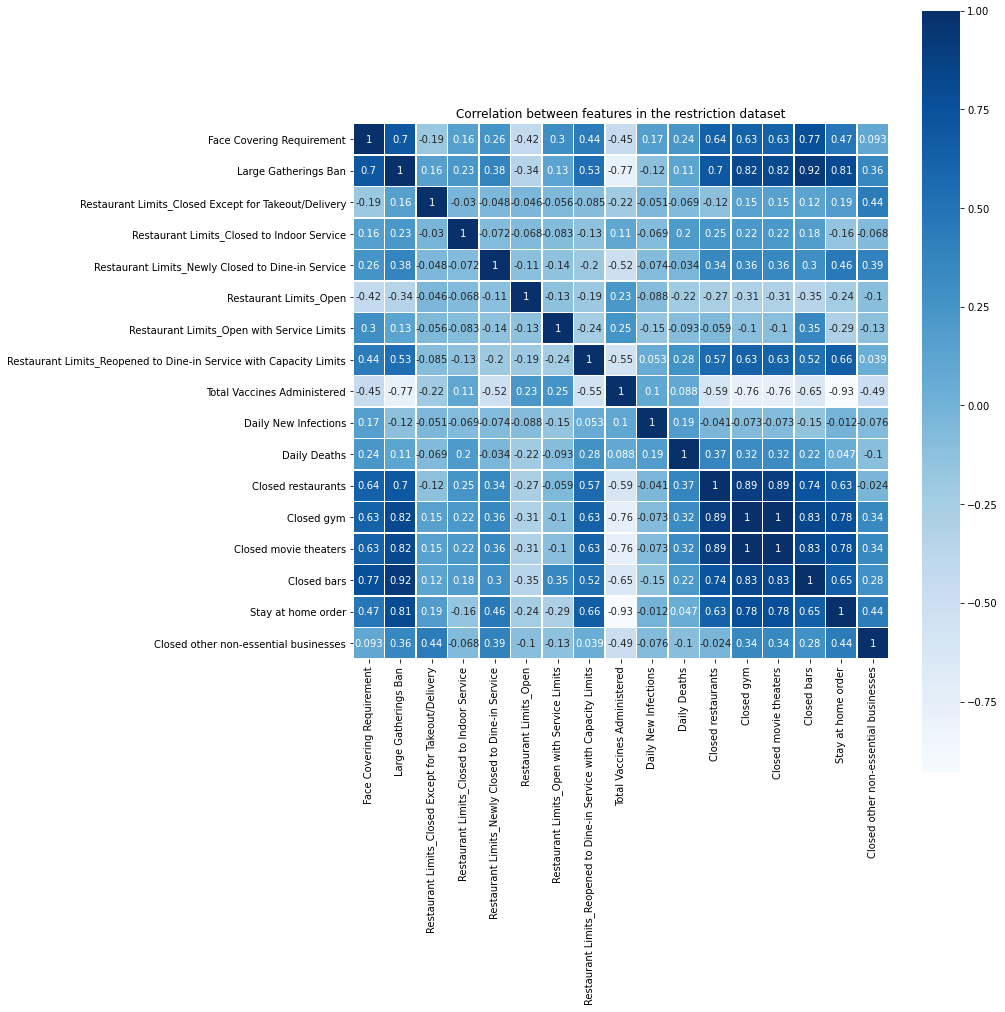

In [333]:
merged_data['Face Covering Requirement'] = merged_data['Face Covering Requirement'].astype(int)

f, ax = plt.subplots(figsize=(12,14))
plt.title('Correlation between features in the restriction dataset')
sns.heatmap(merged_data.corr(),linewidth=0.5,cmap="Blues", square=True,annot=True)

correlation = merged_data.corr()
print("Daily Death's most correlated features: \n")
print(abs(correlation['Daily Deaths']).sort_values(ascending = False), "\n")

To get a better overview of the most important features, we made a correlation plot directly with Daily Deaths.
We notice that it is usually more deaths when there are stricter restrictions. This makes sense considering why the government implements restrictions.

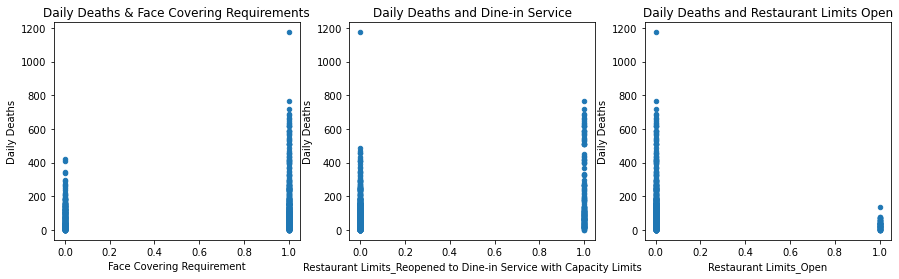

In [330]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3 ,figsize=(15,4))
var = 'Face Covering Requirement' 
ax1.set_title('Daily Deaths & Face Covering Requirements')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths', ax=ax1);
var = 'Restaurant Limits_Reopened to Dine-in Service with Capacity Limits'
ax2.set_title('Daily Deaths and Dine-in Service')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths',ax=ax2);
var = 'Restaurant Limits_Open'
ax3.set_title('Daily Deaths and Restaurant Limits Open')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths',ax=ax3);

We did the same analysis on the mental health data merged with restrictions. 
The value that determines how the average mental health is in California is noticeable correlated with _Total Vaccines Administered_, _Restaurant Limits_Reopened to Dine-in Service with Capacity Limits_ and_Large Gatherings Ban_. <br>
From the correlation plot below we can also notice how some of the restrictions are heavy correlated, such as _Face Covering Requirement_ and _Large Gathering Ban_. For the same reason as mentioned above, this makes sense considering implementation of restrictions. 

In [334]:
correlation = restriction_mental.corr()
print("Mental Health most correlated features: \n")
print(abs(correlation['Mental Health Score']).sort_values(ascending = False), "\n")


Mental Health most correlated features: 

Mental Health Score                                                   1.000000
Closed movie theaters                                                 0.848291
Closed gym                                                            0.848291
Total Vaccines Administered                                           0.812159
Closed restaurants                                                    0.768499
Stay at home order                                                    0.707384
Closed bars                                                           0.677768
Restaurant Limits_Reopened to Dine-in Service with Capacity Limits    0.646949
Large Gatherings Ban                                                  0.635872
Face Covering Requirement                                             0.545250
Daily Deaths                                                          0.434726
Restaurant Limits_Open                                                0.392629
Restaurant

#### Outliers

To get a better overview of potential outliers in the different datasets, we make boxplots.
Many outliers are visible in these pots. Outstanding covid 19 deaths are very interesting for our analysis to get a better understanding of what is causing these 'spikes'.

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.title.set_text('Boxplots of params in Daily Covid Dataset')
ax2.title.set_text('Boxplot of Value in mental health Dataset')
merged_data.boxplot(column=['Daily New Infections'],ax=ax1)
restriction_mental.boxplot(column=['Mental Health Score'],ax=ax2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.title.set_text('Boxplots of params in Covid Deaths by age dataset')
ax2.title.set_text('Boxplot of Covid-19 Deaths in Condition Dataset')
df_sex_age.boxplot(column=['Total Deaths','Pneumonia Deaths','Influenza Deaths','Pneumonia, Influenza, or COVID-19 Deaths'],ax=ax1)
df_condition.boxplot(column=['COVID-19 Deaths'],ax=ax2)


## Feature Engineering

In [ ]:
merged_data["Total Vaccines Administered"] = np.log(merged_data["Total Vaccines Administered"] + 1).fillna(0)
merged_data.head()

### Data Modeling and Inferences

1) Deaths in California by Sex, Age & Condition <br>
2) Plot of Mental Health Value in the US over the year <br>
3) Prediciton of Death Rates based on restrictions <br>
4) Prediciton of Mental Health based on restrictions and Death Rates <br>

#### Deaths in California by Sex, Age & Condition

In [ ]:
init_notebook_mode()

fig = go.Figure()

df_sex_age_grouped = pd.DataFrame(df_sex_age.groupby(['End Date','Age Group'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

    
for name, frame in df_sex_age_grouped.groupby('Age Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in the USA by year and age',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)



In [ ]:
fig = go.Figure()
df_sex_age_cali = df_sex_age[df_sex_age['State']=='California']
df_sex_age_grouped = pd.DataFrame(df_sex_age_cali.groupby(['End Date','Age Group'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

df_sex_age_grouped = df_sex_age_grouped[df_sex_age_grouped['Age Group']!= 'All Ages']
for name, frame in df_sex_age_grouped.groupby('Age Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in California by year and age',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

In [ ]:
fig = go.Figure()
df_sex_age_cali = df_sex_age[df_sex_age['State']=='California']
df_sex_age_grouped = pd.DataFrame(df_sex_age_cali.groupby(['End Date','Sex'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

for name, frame in df_sex_age_grouped.groupby('Sex'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in California by year and Sex',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

In [ ]:
init_notebook_mode()

fig = go.Figure()

grouped_df_condition = pd.DataFrame(df_condition.groupby(['End Date','Condition Group'])["COVID-19 Deaths"].sum())
grouped_df_condition = grouped_df_condition.reset_index()


fig = go.Figure()

    
for name, frame in grouped_df_condition.groupby('Condition Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')
fig.update_layout(title='Total Deaths in California by year and Condition',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

#### Restrictions and Total Deaths

In [ ]:

merged_data_2 = merged_data.copy() 
merged_data_2['Face Change'] = merged_data_2['Face Covering Requirement'].diff()
merged_data_2['Restaurant Change'] = merged_data_2['Restaurant Limits_Open'].diff()

mask_on = merged_data_2[(merged_data_2['Face Change']==1) | (merged_data_2['Face Change']==-1) ]
restaurant_on = merged_data_2[(merged_data_2['Restaurant Change']==1) | (merged_data_2['Restaurant Change']==-1) ]
plt.figure(figsize = (18,8))
merged_data_2.reset_index(inplace=True)
sns.lineplot(x = 'index', y = 'Daily Deaths',data = merged_data_2)
my_label = "mask on"
my_label2 = "mask off"

for index, row in mask_on.iterrows():
    if row['Face Change'] ==1:
        plt.axvline(x = index, color = 'r',
                label = my_label)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'g',
                label = my_label2)
        my_label2 = '_nolegend_'
        
my_label3 = "restaurant close"
my_label4 = "restarant open"
days = datetime.timedelta(3)
for index, row in restaurant_on.iterrows():
    if row['Restaurant Change'] ==1:
        plt.axvline(x = index-days, color = 'b',
                label = my_label3)
        my_label3 = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'y',
                label = my_label4)
        my_label4 = '_nolegend_'
        
        
plt.legend()
plt.title('Covid deaths together with Restrictions')
plt.xlabel('Date')

In [ ]:
restriction_mental_2 = restriction_mental.copy() 

plt.figure(figsize = (18,8))
restriction_mental_2.reset_index(inplace=True)

sns.lineplot(x = 'Time Period End Date', y = 'Mental Health Score',data = restriction_mental_2)

my_label = "mask on"
my_label2 = "mask off"

for index, row in mask_on.iterrows():
    if row['Face Change'] ==1:
        plt.axvline(x = index, color = 'r',
                label = my_label)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'g',
                label = my_label2)
        my_label2 = '_nolegend_'

my_label3 = "restaurant close"
my_label4 = "restarant open"

for index, row in restaurant_on.iterrows():
    if row['Restaurant Change'] ==1:
        plt.axvline(x = index-days, color = 'b',
                label = my_label3)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'y',
                label = my_label)
        my_label2 = '_nolegend_'
        
plt.legend()
plt.title('Mental Health together with Restrictions')
plt.xlabel('Date')


In [ ]:
current_val = 5
start_day = '2020-06-04'
last_date = None
dict_dates = {}

for index, row in merged_data.iterrows():
    if current_val != row['Large Gatherings Ban']:
        dict_dates[start_day] = [last_date,current_val]
        current_val = row['Large Gatherings Ban']
        start_day = index
    else:
        last_date = index

dict_dates[start_day] = [last_date,current_val]
        
color_dict = {5: 'red',4:'orange',3:'yellow',2:'#CAFF70',1:'green',0:'blue'}
plt.figure(figsize = (18,8))
ax =sns.lineplot(x = 'Time Period End Date', y = 'Mental Health Score',data = restriction_mental_2)
for key in dict_dates:
    color = color_dict[dict_dates[key][1]]
    ax.axvspan(key,dict_dates[key][0], color=color, alpha=0.5)


ax.grid(color='#79818f', alpha=0.6, linestyle='solid', linewidth=0.7, axis='x')
ax.grid(color='#2B2A27', alpha=0.6, linestyle='dashed', linewidth=0.7, axis='y')


plt.title('Mental Health together with Large Gatherings')
plt.xlabel('Date')

#### Prediction of Death Rates

In [ ]:
train, val = train_test_split(merged_data, test_size = 0.1, random_state = 42)
Y_train = train["Daily Deaths"]
X_train = train.drop(["Daily Deaths"], axis=1)

linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X_train, Y_train)
y_prediction = linear_model.predict(X_train)
rmse = mean_squared_error(Y_train, y_prediction, squared=False)
rmse
plt.scatter(Y_train, Y_train-y_prediction, alpha=0.5);
rmse
plt.title('test')
plt.xlabel('')
plt.ylabel('')


In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    merged_data.drop('Daily Deaths', axis=1), 
    merged_data['Daily Deaths'], 
    test_size=0.3, shuffle=False)

X_train_.shape, X_test_.shape


In [ ]:
### PLOT STORE DATA ###

y_train_.plot(label='train', figsize=(16,6))
y_test_.plot(label='test')
plt.title("State: {}".format("California")); plt.legend();

In [ ]:
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train_, y_train_)

pred_lr = pd.Series(model.predict(X_test_), index = y_test_.index)
pred_lr.plot(label='linear_regression')
y_test_.plot(label='true value', figsize=(10,6));
plt.title("Prediction of Deaths in California"); plt.legend();
plt.xlabel('Date')
plt.ylabel('Deaths')
print("This models RMSE:", mean_squared_error(y_test_, pred_lr,squared=False))

#### Model improvement

Tried to improve the model by combining several other linear models. <br>
Unfortunately this dis not provide great improvements.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train_, y_train_)
pred_ridge= pd.Series(ridge.predict(X_test_), index = y_test_.index)
print("Ridge model RMSE:", mean_squared_error(y_test_, pred_ridge,squared=False))

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_, y_train_)
pred_lasso= pd.Series(lasso.predict(X_test_), index = y_test_.index)
print("Lasso model RMSE:", mean_squared_error(y_test_, pred_lasso,squared=False))
average_pred = (pred_lr+pred_lasso+pred_ridge)/3
print("Average RMSE:", mean_squared_error(y_test_, average_pred,squared=False))


## More advanced regressors

We decieded to try som other strong regressor models. Both of these algorithms used Gradient Boosted Machines, which gives a prediction model in the form of an ensemble of weak prediction models with decision trees.

In [ ]:
!{sys.executable} -m pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train_, y_train_)
xgb_pred_hat = pd.Series(xgb_model.predict(X_test_), index = y_test_.index)
print("Average RMSE for XGBRegressor:", mean_squared_error(y_test_, xgb_pred_hat,squared=False))

In [ ]:
!{sys.executable} -m pip install lightgbm
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor()

lgb_model.fit(X_train_, y_train_)
lgb_pred_hat = lgb_model.predict(X_test_)
print("Average RMSE for LightBM regressor:", mean_squared_error(y_test_, lgb_pred_hat,squared=False))

### Hyperparameter tuning

The models performed decent. Try to improve performance even further by tuning the parameters.

In [ ]:
n_estimators = [500, 550, 600, 650]
max_depth = [4,5,7,9,10]
booster = ['gbtree']
learning_rate = [0.2,0.4,0.5]
min_child_weight = [0.5,2,3,4]
base_score = [0.5]
subsample = [0.5, 0.6,1.2,1.5]
tree_method='gpu_hist'
regressor = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'booster': booster,
    'base_score': base_score,
    'subsample': subsample
}
random_cv = RandomizedSearchCV(estimator = regressor, 
                              param_distributions = hyperparameter_grid,
                              cv=5,
                              n_iter = 50,
                              scoring = 'neg_mean_squared_error',
                              n_jobs = 4,
                              verbose = 5,
                              return_train_score = True,
                              random_state = 42)
random_cv.fit(X_train_, y_train_)
xgb_params = random_cv.best_params_
xgb_model = xgb.XGBRegressor(**xgb_params)

In [ ]:
print(xgb_params)

In [ ]:
xgb_model.fit(X_train_, y_train_)
xgb_pred_hat_2 = xgb_model.predict(X_test_)
print("Average RMSE for XGBRegressor with tuned parameters:", mean_squared_error(y_test_, xgb_pred_hat_2,squared=False))

In [ ]:
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,25],'max_depth':[1,3,10,20],
             'learning_rate':[0.05,0.2,0.3],'reg_alpha':[0,0.01,0.03,0.1]}
lgb_model2 = lgb.LGBMRegressor()
clf=RandomizedSearchCV(lgb_model2,parameters,n_iter=100)
clf.fit(X=X_train_, y=y_train_)
print(clf.best_params_)

In [ ]:
lgb_pred_hat_2 = clf.predict(X_test_)
print("Average RMSE for LGBMRegressor with tuned parameters:", mean_squared_error(y_test_, lgb_pred_hat_2,squared=False))



After tuning the different hyperparameters, we could not improve the importance any further compared to the model that used the default parameters.

We therefore decided to use the LightGBM with the default parameters as our final prediction.

In [ ]:
pd.Series(lgb_pred_hat, index = y_test_.index).plot(label='LGBM Regressor')
y_test_.plot(label='true value', figsize=(10,6));
plt.title("Prediction of Deaths in California"); plt.legend();
plt.xlabel('Date')
plt.ylabel('Deaths')

#### Feature Importance

In [ ]:
xgb.plot_importance(xgb_model)
lgb.plot_importance(lgb_model)

#### Prophet

In [ ]:
!{sys.executable} -m pip install pystan==2.19.1.1
!{sys.executable} -m pip install fbprophet
import fbprophet

from fbprophet import Prophet
model = Prophet()

hans_data = merged_data.copy().reset_index()
hans_data = hans_data.rename(columns={"index": "ds", "Daily Deaths": "y"})
model.fit(hans_data)
future = model.make_future_dataframe(periods=180)
future.tail()
forecast = model.predict(future)

fig1 = model.plot(forecast)
axes = fig1.get_axes()
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Deaths')
axes[0].set_title('Prediction of future with Prophet')


#### Prediction of Mental Health

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    restriction_mental.drop('Mental Health Score', axis=1), 
    restriction_mental['Mental Health Score'], 
    test_size=0.3, shuffle=False)

model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train_, y_train_)

pred_lr = pd.Series(model.predict(X_test_), index = y_test_.index)
pred_lr.plot(label='linear_regression')
y_test_.plot(label='true', figsize=(10,6));